**Config**

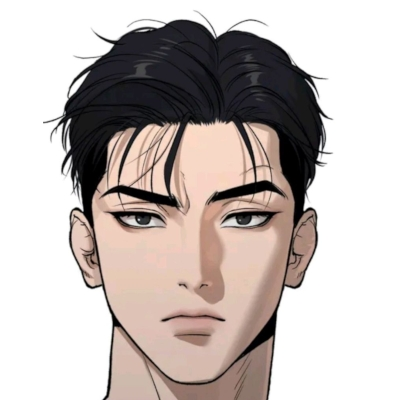

In [85]:
import torch
from vid2img import VideoToImage
from io import BytesIO
import PIL
from IPython.display import display, Image, HTML


def display_img_array(ima):
    display(Image(ima))

# edit the config
device = torch.device('cuda:0')
dataset_name = 'vox' # ['vox', 'taichi', 'ted', 'mgif']
source_image_path = './assets/demo2.jpg'
driving_video_path = './assets/demo2.mp4'
output_video_path = './result/generated.mp4'
config_path = 'config/vox-256.yaml'
checkpoint_path = 'checkpoints/vox.pth.tar'
predict_mode = 'relative' # ['standard', 'relative', 'avd']
find_best_frame = True # when use the relative mode to animate a face, use 'find_best_frame=True' can get better quality result

pixel = 256 # for vox, taichi and mgif, the resolution is 256*256
if(dataset_name == 'ted'): # for ted, the resolution is 384*384
    pixel = 384

display(Image(source_image_path))


**Read image and video**

In [86]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread(source_image_path)
reader = imageio.get_reader(driving_video_path)


source_image = resize(source_image, (pixel, pixel))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (pixel, pixel))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

#HTML(display(source_image, driving_video).to_html5_video())

**Create a model and load checkpoints**

In [87]:
from demo import load_checkpoints
inpainting, kp_detector, dense_motion_network, avd_network = load_checkpoints(config_path = config_path, checkpoint_path = checkpoint_path, device = device)

**Perform image animation**

In [88]:
from demo import make_animation
from skimage import img_as_ubyte

if predict_mode=='relative' and find_best_frame:
    from demo import find_best_frame as _find
    i = _find(source_image, driving_video, device.type=='cpu')
    print ("Best frame: " + str(i))
    driving_forward = driving_video[i:]
    driving_backward = driving_video[:(i+1)][::-1]
    predictions_forward = make_animation(source_image, driving_forward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions_backward = make_animation(source_image, driving_backward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions = predictions_backward[::-1] + predictions_forward[1:]
else:
    predictions = make_animation(source_image, driving_video, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)

#save resulting video
imageio.mimsave(output_video_path, [img_as_ubyte(frame) for frame in predictions], fps=fps)

#HTML(display(source_image, driving_video, predictions).to_html5_video())

180it [00:09, 18.83it/s]


Best frame: 58


100%|██████████| 59/59 [00:04<00:00, 13.20it/s]


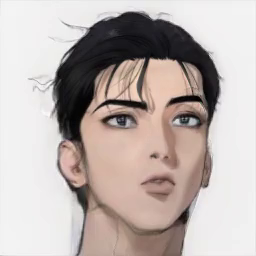

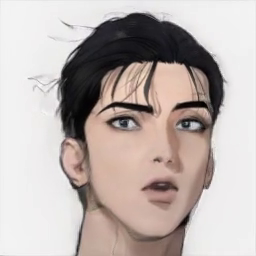

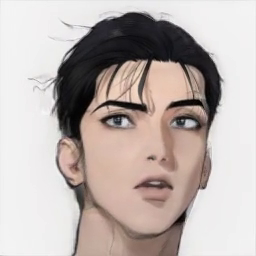

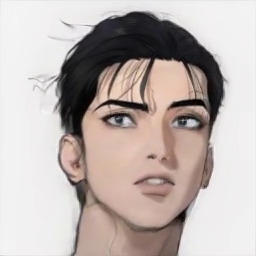

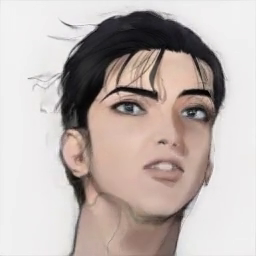

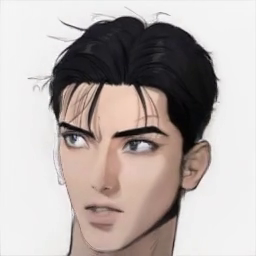

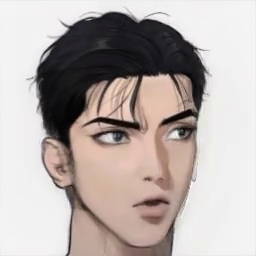

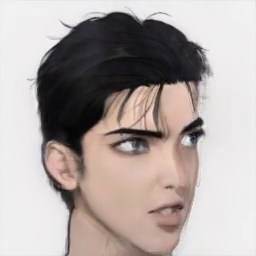

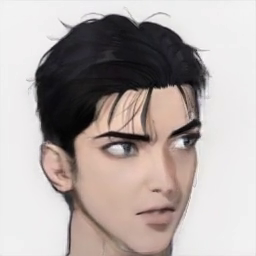

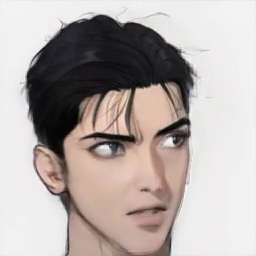

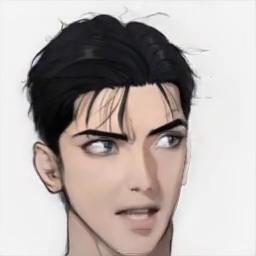

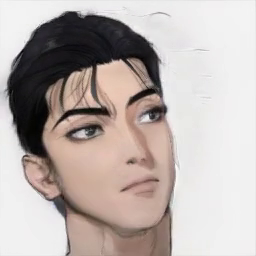

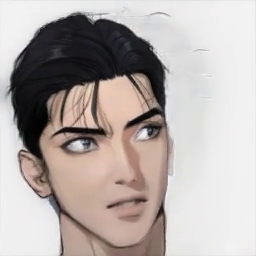

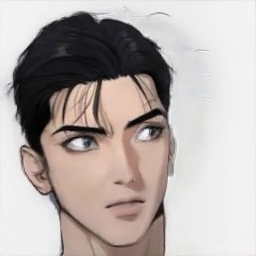

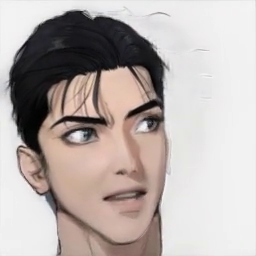

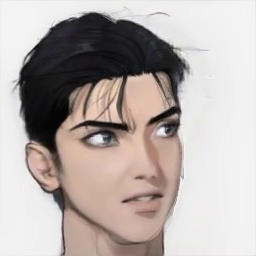

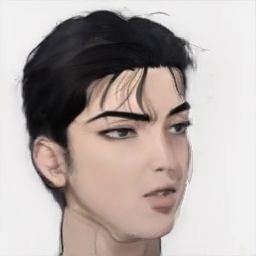

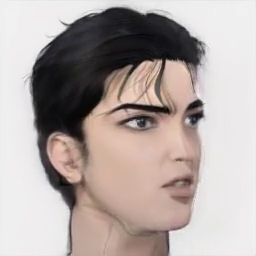

In [89]:
from IPython.display import display, Image, HTML

videoToImage = VideoToImage(savePath="./result", videoPath="./result/generated.mp4")
savedImageList = videoToImage.saveImage()



for image in savedImageList:
    display(Image(image))